# Multi-Asset Portfolio Management Demo

This notebook demonstrates the complete portfolio management workflow:

1. **Data Loading** - Load multiple futures contracts (ES, GC)
2. **Signal Generation** - Create momentum signals for each asset
3. **Portfolio Backtest** - Run multi-asset backtest with rebalancing
4. **Performance Analysis** - Calculate metrics and analyze results
5. **Report Generation** - Create interactive HTML report

## Architecture

```
PortfolioManager (orchestrator)
    ├── Signal generators per asset
    ├── Position tracking and rebalancing
    └── Reporter (HTML reports with interactive charts)
```

In [15]:
# Add project root to path
import sys
from pathlib import Path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /Users/Sakarias/QuantTrading


In [23]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime

# Core portfolio management
from core.portfolio_manager import (
    PortfolioManager,
    PortfolioConfig,
    BacktestResult,
    run_multi_asset_backtest
)

# Data loading and signals
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2

# Reporting
from core.reporter import Reporter, quick_report

print("✅ All modules imported successfully")

✅ All modules imported successfully


## Step 1: Load Market Data

Load futures data for:
- **ES** - E-mini S&P 500 futures (equity exposure)
- **GC** - Gold futures (commodity/diversification)

In [24]:
# Load data for multiple assets
tickers = ['ES', 'GC']
start_date = '2015-01-01'
end_date = '2024-12-31'

print(f"Loading data for {len(tickers)} assets...")
print(f"Period: {start_date} to {end_date}\n")

prices = load_assets(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date
)

# Display data summary
for ticker, df in prices.items():
    print(f"{ticker}:")
    print(f"  Rows: {len(df):,}")
    print(f"  Period: {df.index[0].date()} to {df.index[-1].date()}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    print()

Loading data for 2 assets...
Period: 2015-01-01 to 2024-12-31


Loading 2 assets: ['ES', 'GC']
✓ ES: 6134 rows, 2000-09-18 to 2024-12-31
✓ GC: 6106 rows, 2000-08-30 to 2024-12-31

Common date range: 2000-09-18 to 2024-12-31
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515
  GC: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
GC: 2515/2515 valid dates (100.0%)
ES:
  Rows: 2,515
  Period: 2015-01-02 to 2024-12-31
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
  Price range: $1824.50 - $6099.00

GC:
  Rows: 2,515
  Period: 2015-01-02 to 2024-12-31
  Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
  Price range: $1050.80 - $2788.50



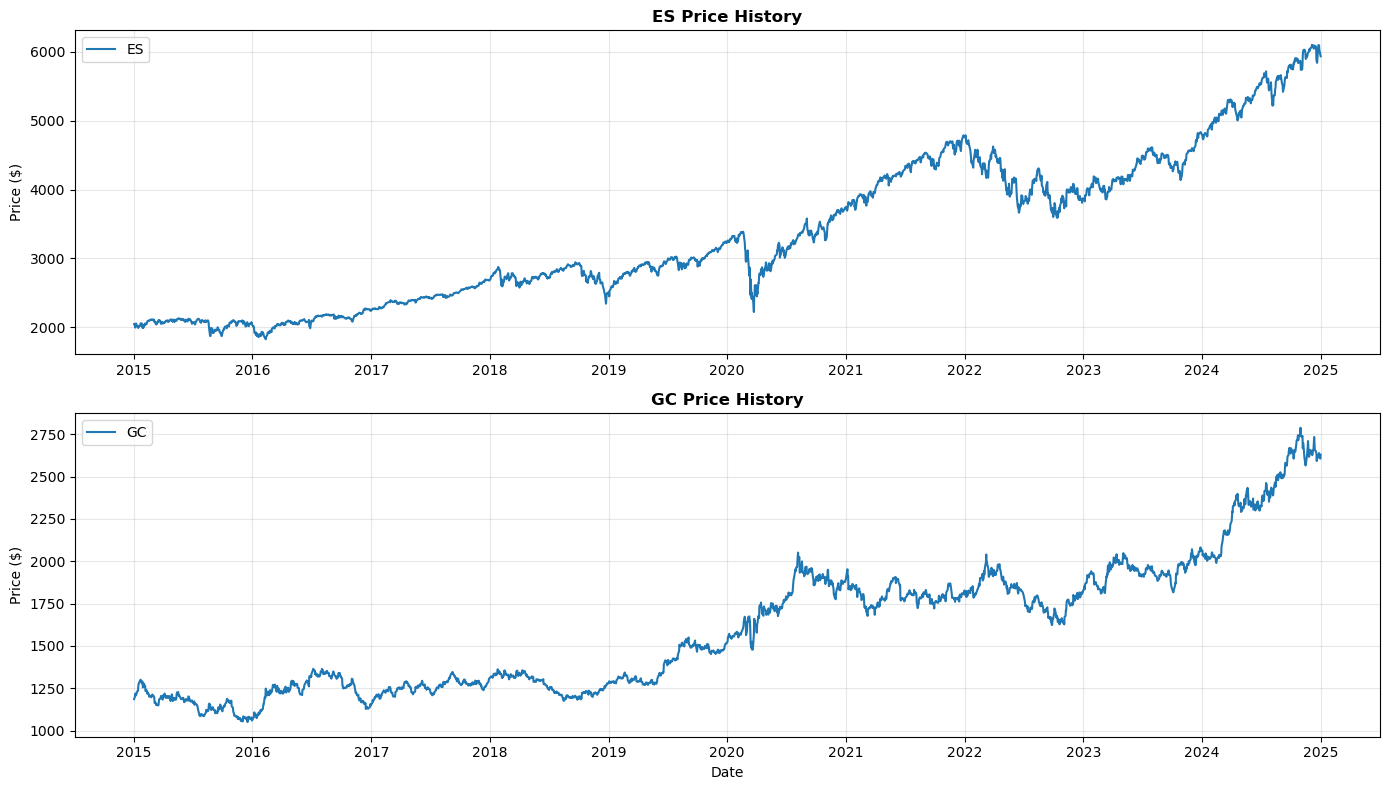

In [18]:
# Quick visualization of price history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 4*len(tickers)))
if len(tickers) == 1:
    axes = [axes]

for idx, (ticker, df) in enumerate(prices.items()):
    axes[idx].plot(df.index, df['Close'], linewidth=1.5, label=ticker)
    axes[idx].set_title(f"{ticker} Price History", fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Price ($)', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

## Step 2: Generate Trading Signals

Create momentum signals for each asset using:
- **Lookback**: 120 days (~6 months)
- **Logic**: Long when price > SMA(200)

In [25]:
# Initialize signal generator
signal_generator = MomentumSignalV2(
    lookback=120,  # 6-month momentum
    entry_threshold=0.02,
    exit_threshold=-0.01,
    sma_filter=200
)

print(f"Signal Generator: {signal_generator.__class__.__name__}")
print(f"Lookback: {signal_generator.lookback} days")
print(f"SMA Filter: {signal_generator.sma_filter} days\n")

# Wrap signal generator for multi-asset use
multi_signal = SingleAssetWrapper(signal_generator)

# Generate signals for each asset
signals = multi_signal.generate(prices)

print(f"✓ Generated signals for {len(signals)} assets")
for ticker in signals.keys():
    print(f"  {ticker}: {len(signals[ticker])} bars")

Signal Generator: MomentumSignalV2
Lookback: 120 days
SMA Filter: 200 days

✓ Generated signals for 2 assets
  ES: 2515 bars
  GC: 2515 bars


In [26]:
# Analyze signal statistics
print("\n" + "="*60)
print("SIGNAL SUMMARY")
print("="*60)

for ticker in tickers:
    sig = signals[ticker]['Signal']  # Note: SingleAssetWrapper converts 'Position' to 'Signal'
    
    n_long = (sig == 1).sum()
    n_short = (sig == -1).sum()
    n_flat = (sig == 0).sum()
    
    print(f"\n{ticker}:")
    print(f"  Long days:  {n_long:4d} ({n_long/len(sig)*100:.1f}%)")
    print(f"  Short days: {n_short:4d} ({n_short/len(sig)*100:.1f}%)")
    print(f"  Flat days:  {n_flat:4d} ({n_flat/len(sig)*100:.1f}%)")
    
    # Count signal changes (potential trades)
    signal_changes = (sig.diff() != 0).sum()
    print(f"  Signal changes: {signal_changes}")


SIGNAL SUMMARY

ES:
  Long days:  2216 (88.1%)
  Short days:    0 (0.0%)
  Flat days:   299 (11.9%)
  Signal changes: 2

GC:
  Long days:  2241 (89.1%)
  Short days:    0 (0.0%)
  Flat days:   274 (10.9%)
  Signal changes: 2


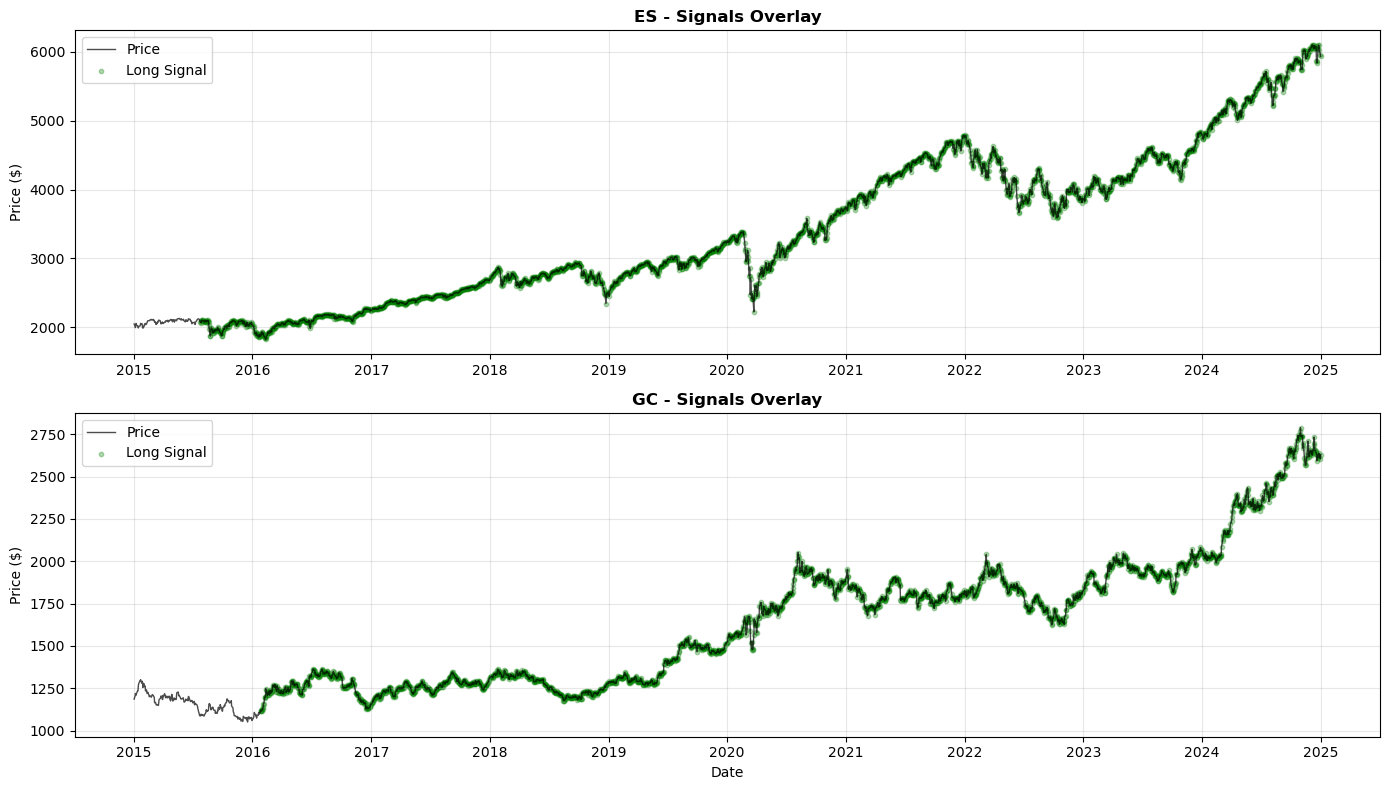

In [ ]:
# Visualize signals over time
fig, axes = plt.subplots(len(tickers), 1, figsize=(14, 4*len(tickers)))
if len(tickers) == 1:
    axes = [axes]

for idx, ticker in enumerate(tickers):
    df = prices[ticker].copy()
    df['Signal'] = signals[ticker]['Signal']
    
    # Plot price
    axes[idx].plot(df.index, df['Close'], color='black', linewidth=1, alpha=0.7, label='Price')
    
    # Highlight long periods
    long_periods = df[df['Signal'] == 1]
    axes[idx].scatter(long_periods.index, long_periods['Close'], 
                     color='green', s=10, alpha=0.3, label='Long Signal')
    
    axes[idx].set_title(f"{ticker} - Signals Overlay", fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Price ($)', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

## Step 3: Configure Portfolio

Set up portfolio parameters:
- **Initial Capital**: $100,000
- **Rebalance Threshold**: 5% drift triggers rebalancing
- **Transaction Costs**: 3 basis points (0.03%)
- **Allocation**: Equal weight among active signals

In [27]:
# Configure portfolio
config = PortfolioConfig(
    initial_capital=100000.0,
    rebalance_threshold=0.05,  # 5% drift
    transaction_cost_bps=3.0    # 3 bps
)

print("Portfolio Configuration:")
print(f"  Initial Capital: ${config.initial_capital:,.0f}")
print(f"  Rebalance Threshold: {config.rebalance_threshold:.1%}")
print(f"  Transaction Costs: {config.transaction_cost_bps:.1f} bps")
print(f"\nAllocation Strategy: Equal weight among active signals")

Portfolio Configuration:
  Initial Capital: $100,000
  Rebalance Threshold: 5.0%
  Transaction Costs: 3.0 bps

Allocation Strategy: Equal weight among active signals


## Step 4: Run Backtest

Execute the multi-asset portfolio backtest with:
- Signal-based entries/exits
- Automatic rebalancing when drift exceeds threshold
- Transaction cost tracking

In [36]:
# Run backtest
print("Running backtest...\n")

result, equity_df, trades_df = run_multi_asset_backtest(
    signals_dict=signals,
    prices_dict=prices,
    config=config,
    return_pm=False  # Return lightweight BacktestResult
)

print(f"✅ Backtest completed!")
print(f"   Period: {equity_df['Date'].iloc[0].date()} to {equity_df['Date'].iloc[-1].date()}")
print(f"   Trading days: {len(equity_df):,}")
print(f"   Total trades: {len(trades_df)}")

Running backtest...

✅ Backtest completed!
   Period: 2015-01-02 to 2024-12-31
   Trading days: 2,515
   Total trades: 16


## Step 5: Analyze Results

Calculate comprehensive performance metrics

In [29]:
# Calculate metrics
metrics = result.calculate_metrics()

# Display in console
quick_report(equity_df, trades_df, metrics)


BACKTEST RESULTS
Total Return: 178.20%
CAGR: 10.80%
Annual Volatility: 11.30%
Sharpe Ratio: 0.964
Max Drawdown: -19.78%
Total Trades: 16
Rebalances: 14
Transaction Costs: 88.4878
TC as % of Capital: 0.0009

TRADES SUMMARY
Total trades: 16

By type:
Type
Rebalance    14
Entry         2
Name: count, dtype: int64

By ticker:
Ticker
GC    8
ES    8
Name: count, dtype: int64


In [30]:
# Display key metrics as a formatted table
metrics_df = pd.DataFrame([
    {'Metric': k, 'Value': v} for k, v in metrics.items()
])

# Format values
def format_metric(row):
    value = row['Value']
    metric = row['Metric']
    
    if isinstance(value, float):
        if 'Return' in metric or 'CAGR' in metric or 'Volatility' in metric or 'Drawdown' in metric:
            return f"{value:.2%}"
        elif 'Ratio' in metric:
            return f"{value:.3f}"
        else:
            return f"{value:.2f}"
    return str(value)

metrics_df['Value'] = metrics_df.apply(format_metric, axis=1)

display(metrics_df)

,Metric,Value
0,Total Return,178.20%
1,CAGR,10.80%
2,Annual Volatility,11.30%
3,Sharpe Ratio,0.964
4,Max Drawdown,-19.78%
5,Total Trades,16.00
6,Rebalances,14.00
7,Transaction Costs,88.49
8,TC as % of Capital,0.00


In [31]:
# Analyze trade distribution
if not trades_df.empty:
    print("\n" + "="*60)
    print("TRADE ANALYSIS")
    print("="*60)
    
    # By type
    if 'Type' in trades_df.columns:
        print("\nTrades by Type:")
        print(trades_df['Type'].value_counts())
    
    # By asset
    if 'Ticker' in trades_df.columns:
        print("\nTrades by Asset:")
        print(trades_df['Ticker'].value_counts())
    
    # Transaction costs
    if 'TransactionCost' in trades_df.columns:
        total_tc = trades_df['TransactionCost'].sum()
        total_volume = trades_df['Value'].abs().sum()
        print(f"\nTransaction Costs:")
        print(f"  Total: ${total_tc:.2f}")
        print(f"  As % of initial capital: {total_tc/config.initial_capital:.4%}")
        print(f"  As % of traded volume: {total_tc/total_volume:.4%}")
    
    # Display recent trades
    print("\nRecent Trades:")
    display(trades_df.tail(10))


TRADE ANALYSIS

Trades by Type:
Type
Rebalance    14
Entry         2
Name: count, dtype: int64

Trades by Asset:
Ticker
GC    8
ES    8
Name: count, dtype: int64

Transaction Costs:
  Total: $88.49
  As % of initial capital: 0.0885%
  As % of traded volume: 0.0300%

Recent Trades:


,Date,Ticker,Type,Shares,Price,Value,TransactionCost,Signal,PrevSignal,Note,CurrentValue,TargetValue
6,2018-08-16,ES,Rebalance,-2.288228,2844.750000,-6509.437080,1.952831,1.0,NaN,NaN,69461.833579,62952.396499
7,2018-08-16,GC,Rebalance,5.534295,1176.199951,6509.437080,1.952831,1.0,NaN,NaN,56442.959419,62952.396499
8,2018-12-20,ES,Rebalance,2.538920,2485.750000,6311.119254,1.893336,1.0,NaN,NaN,55007.968924,61319.088178
9,2018-12-20,GC,Rebalance,-4.994555,1263.599976,-6311.119254,1.893336,1.0,NaN,NaN,67630.207432,61319.088178
10,2020-03-12,ES,Rebalance,3.284434,2469.000000,8109.268236,2.432780,1.0,NaN,NaN,60905.895087,69015.163323
11,2020-03-12,GC,Rebalance,-5.102415,1589.300049,-8109.268236,2.432780,1.0,NaN,NaN,77124.431559,69015.163323
12,2020-06-05,ES,Rebalance,-2.555804,3186.750000,-8144.708612,2.443413,1.0,NaN,NaN,89078.198347,80933.489735
13,2020-06-05,GC,Rebalance,4.859032,1676.199951,8144.708612,2.443413,1.0,NaN,NaN,72788.781123,80933.489735
14,2021-03-30,ES,Rebalance,-2.400764,3947.750000,-9477.615911,2.843285,1.0,NaN,NaN,100260.511211,90782.895300
15,2021-03-30,GC,Rebalance,5.628372,1683.900024,9477.615911,2.843285,1.0,NaN,NaN,81305.279388,90782.895300


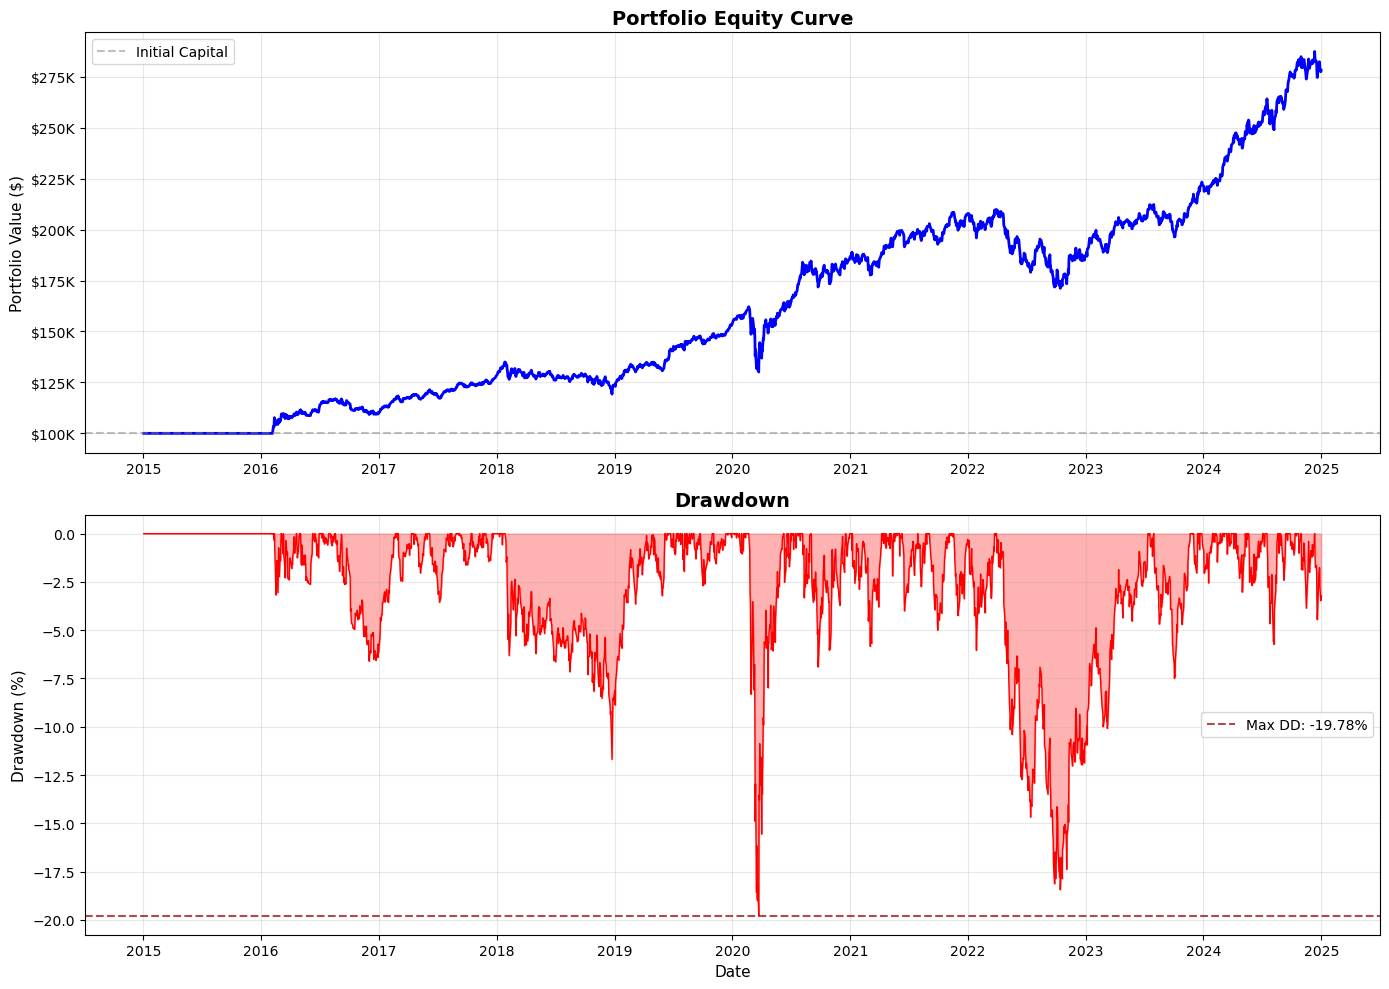

In [32]:
# Plot equity curve
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
equity_df_plot = equity_df.set_index('Date') if 'Date' in equity_df.columns else equity_df
ax1.plot(equity_df_plot.index, equity_df_plot['TotalValue'], linewidth=2, color='blue')
ax1.axhline(y=config.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Drawdown
cumulative = equity_df_plot['TotalValue'] / equity_df_plot['TotalValue'].iloc[0]
peak = cumulative.cummax()
drawdown = (cumulative - peak) / peak * 100

ax2.fill_between(drawdown.index, 0, drawdown.values, color='red', alpha=0.3)
ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=metrics['Max Drawdown']*100, color='darkred', linestyle='--', 
           alpha=0.7, label=f'Max DD: {metrics["Max Drawdown"]:.2%}')
ax2.legend()

plt.tight_layout()
plt.show()

## Step 6: Generate Interactive HTML Report

Create a comprehensive HTML report with:
- Interactive Plotly charts
- Performance metrics table
- Trade analysis
- Worst days identification
- Monthly returns heatmap

In [33]:
# Initialize reporter
reporter = Reporter(output_dir='reports')

# Generate filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report_filename = f"multi_asset_backtest_{timestamp}.html"
report_path = project_root / 'reports' / report_filename

print(f"Generating HTML report...")
print(f"Output: {report_path}")

Generating HTML report...
Output: /Users/Sakarias/QuantTrading/reports/multi_asset_backtest_20251124_201908.html


In [34]:
# Generate report
html_content = reporter.generate_html_report(
    equity_df=equity_df,
    trades_df=trades_df,
    metrics=metrics,
    title="Multi-Asset Portfolio Backtest",
    save_path=str(report_path)
)

print(f"\n✅ Report generated successfully!")
print(f"\nTo view the report, open: {report_path}")

✅ Report saved to: /Users/Sakarias/QuantTrading/reports/multi_asset_backtest_20251124_201908.html

✅ Report generated successfully!

To view the report, open: /Users/Sakarias/QuantTrading/reports/multi_asset_backtest_20251124_201908.html


/Users/Sakarias/QuantTrading/core/reporter.py:375: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## Summary

This notebook demonstrated:

1. ✅ **Multi-asset data loading** with automatic alignment
2. ✅ **Signal generation** using momentum strategies
3. ✅ **Portfolio backtesting** with rebalancing and transaction costs
4. ✅ **Performance analysis** with comprehensive metrics
5. ✅ **HTML report generation** with interactive charts

### Key Takeaways

- The modular architecture makes it easy to:
  - Swap signal strategies
  - Add more assets
  - Adjust portfolio parameters
  - Generate professional reports

- The BacktestResult object provides:
  - Clean interface for metrics
  - Lightweight storage for walk-forward optimization
  - Easy integration with Reporter

### Next Steps

1. **Risk Management**: Implement position sizing rules
2. **Walk-Forward**: Add strategy selection per asset
3. **Multi-Strategy**: Combine multiple signals per asset
4. **Live Trading**: Extend for real-time execution

In [37]:
# Optional: Compare with benchmark (buy-and-hold ES)
print("\n" + "="*60)
print("BENCHMARK COMPARISON (Buy & Hold ES)")
print("="*60)

# Calculate buy & hold returns
es_prices = prices['ES']['Close']
es_aligned = es_prices.reindex(equity_df['Date'] if 'Date' in equity_df.columns else equity_df.index)
es_aligned = es_aligned.fillna(method='ffill')

# Buy & hold equity curve
bh_shares = config.initial_capital / es_aligned.iloc[0]
bh_equity = es_aligned * bh_shares

bh_return = (bh_equity.iloc[-1] / config.initial_capital) - 1
bh_vol = es_aligned.pct_change().std() * np.sqrt(252)
bh_sharpe = (bh_return / (len(es_aligned)/252)) / bh_vol if bh_vol > 0 else 0

print(f"\nBenchmark (ES Buy & Hold):")
print(f"  Total Return: {bh_return:.2%}")
print(f"  Volatility: {bh_vol:.2%}")
print(f"  Sharpe: {bh_sharpe:.3f}")

print(f"\nStrategy vs Benchmark:")
print(f"  Return Difference: {metrics['Total Return'] - bh_return:.2%}")
print(f"  Sharpe Difference: {metrics['Sharpe Ratio'] - bh_sharpe:.3f}")


BENCHMARK COMPARISON (Buy & Hold ES)

Benchmark (ES Buy & Hold):
  Total Return: 190.08%
  Volatility: 17.83%
  Sharpe: 1.068

Strategy vs Benchmark:
  Return Difference: -11.88%
  Sharpe Difference: -0.104


/var/folders/nz/j4jbvftx68bd6h7_50gvnh180000gn/T/ipykernel_60851/2201333993.py:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

